In [2]:
#
# Work through example 9.4 in book
# Chemical Reactor Analysis and Design Fundamentals - Rawlings and Ekerdt
#
# Code from book at
# https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/ch9/fig-9-21.html
#

In [3]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import pyomo.dae as dae
import scipy.stats as spstat

from pyomo.contrib.pynumero.interfaces.pyomo_nlp import PyomoNLP
from pyomo.contrib.pynumero.sparse import BlockSymMatrix, BlockMatrix, BlockVector
from scipy.sparse import identity
from scipy.sparse.linalg import spsolve

import get_redHessian as hess

In [4]:
# get data
data_df = pd.read_csv('ex_9_4_data.csv')
data_df.head()

,t,ca_meas
0,0.000000,2.005422
1,0.050505,1.753623
2,0.101010,1.788886
3,0.151515,1.532534
4,0.202020,1.438015


In [5]:
data = [{'ca_meas': {k:v for (k, v) in zip(data_df.t, data_df.ca_meas)}}]
t_meas = data_df.t
ca_meas = data[0]['ca_meas']

In [6]:
def create_model(data):

    m = pyo.ConcreteModel()

    m.t = dae.ContinuousSet(bounds = (0.0, 5.0), initialize = t_meas)
    m.ca = pyo.Var(m.t, initialize = 0.0, bounds = (0.0, 5.0))
    m.ca0 = pyo.Var(initialize = 1.0, bounds = (1.0, 3.0))
    m.n = pyo.Var(initialize = 1, bounds = (1.0e-3, 5))
    m.k = pyo.Var(initialize = 0.1, bounds = (1.0e-3, 5))

    m.dca = dae.DerivativeVar(m.ca, wrt = m.t)

    def _rate_cons(m, t):
        if t == 0:
            return pyo.Constraint.Skip
        else:
            expr = m.dca[t] == -m.k * m.ca[t] ** m.n
        return expr
    m.rate_cons = pyo.Constraint(m.t, rule = _rate_cons)

    def _initcon(m):
        return m.ca[0] == m.ca0
    m.initcon = pyo.Constraint(rule = _initcon)

    def _ssq(m):
        expr = sum((m.ca[t] - ca_meas[t])**2 for t in t_meas)
        return expr
    m.ssq = pyo.Objective(rule = _ssq)
    
    disc = pyo.TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=100, ncp=2)
    
    return m

In [8]:
mest = create_model(data)
solver = pyo.SolverFactory('ipopt')
solver.solve(mest, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1602
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      603

Total number of variables............................:      404
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      204


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 401, 'Number of variables': 404, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.11332082748413086}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
# Estimated parameters
print("ca0:", mest.ca0(), "k:", mest.k(), "n:", mest.n())

ca0: 1.9054870413248208 k: 0.4650665657230729 n: 2.3753991642221277


In [11]:
nlp = PyomoNLP(mest)
parm_vars = [mest.ca0, mest.k, mest.n]
Hred = hess.getHred(nlp, parm_vars)
print("Hessian from pynumero:")
print(Hred)

Hessian from pynumero:
[[ 11.38741997 -19.19027396  -2.24618486]
 [-19.19027396 106.4412372    1.34078414]
 [ -2.24618486   1.34078414   1.52492085]]


In [13]:
n = len(ca_meas)
p = 3
s2 = mest.ssq() / (n - p)
n, p, s2

(100, 3, 0.009991380723359535)

In [14]:
# Covariance Matrix
cov = 2 * s2 * np.linalg.inv(Hred)
cov

matrix([[0.00379661, 0.00062092, 0.0050464 ],
        [0.00062092, 0.00029139, 0.00065841],
        [0.0050464 , 0.00065841, 0.0199585 ]])

In [15]:
parm_sd = np.sqrt(np.diag(cov))
conf_mult = np.sqrt(p * spstat.f.ppf(0.95, p, n - p))
print("conf multiplier:", conf_mult)
conf_int = conf_mult * parm_sd
print("confidence interval delta from nominal [ca0, k, n]")
print(conf_int)

conf multiplier: 2.845205197978177
confidence interval delta from nominal [ca0, k, n]
[0.17531202 0.04856789 0.40195511]


In [16]:
# plot predicted ca vs measured
ms = create_model(data)
ms.ca0.fix(mest.ca0())
ms.k.fix(mest.k())
ms.n.fix(mest.n())
solver = pyo.SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1201
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      201

Total number of variables............................:      401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 401, 'Number of variables': 401, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.052865028381347656}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Text(0, 0.5, 'ca')

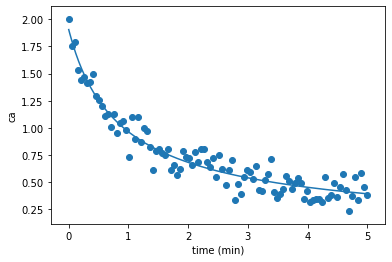

In [20]:
fig, ax = plt.subplots()
ax.plot(list(ms.t), [ms.ca[t]() for t in ms.t])
ax.scatter(data[0]['ca_meas'].keys(), data[0]['ca_meas'].values())
ax.set_xlabel('time (min)')
ax.set_ylabel('ca')